In [22]:
import pandas as pd
import numpy as np
from scipy import stats
import re
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportion_confint
import statsmodels.stats.multitest as multi

   Hugo_Symbol  counts_x  counts_y  poisson_p_tail1  poisson_p_tail2
0        ASXL1        20      17.0         0.297028         0.440907
1       DNMT3A        75      79.0         0.296799         0.530658
2         GNB1         5       5.0         0.384039         0.615961
3       HIVEP2         7       5.0         0.300708         0.401286
4         JAK2         6      14.0         0.001400         0.606303
5     KIAA0141         3       0.0         0.049787         0.352768
6        KRBA2         3       0.0         0.049787         0.352768
7   LY75-CD302         3       0.0         0.049787         0.352768
8        PPM1D        11       5.0         0.037520         0.420733
9        SF3B1        20      11.0         0.021387         0.440907
10       SRCAP         8       6.0         0.313374         0.407453
11        TET2        26      36.0         0.024380         0.551904
12        TP53         8       6.0         0.313374         0.407453
13      ZBTB33        10       5.0

/Users/mleventh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/mleventh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:102: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


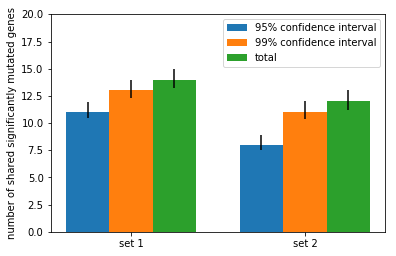

In [24]:
input1="statistical_validation/all_clone/mut_lim/set1.txt"
input2="statistical_validation/all_clone/mut_lim/set2.txt"
set1=pd.read_csv(input1,sep='\t')
set2=pd.read_csv(input2,sep='\t')

sig_list="statistical_validation/all_clone/mut_lim/sig_genes_set1_RNA.txt"
sig_gene_valid=pd.read_csv(sig_list,sep='\t')
sig_gene_valid=sig_gene_valid[sig_gene_valid['q']<0.1]
sig_gene_valid.loc[sig_gene_valid['gene'].str.match("LY75"),'gene']="LY75-CD302"
#sig_gene_valid.loc[sig_gene_valid['gene'].str.match("KIAA0141"),'gene']="DELE1"
#sig_gene_valid.loc[sig_gene_valid['gene'].str.match("ZMYND17"),'gene']="MSS51"

set1=set1.loc[set1['Hugo_Symbol'].isin(sig_gene_valid['gene']),:]

set2=set2.loc[set2['Hugo_Symbol'].isin(sig_gene_valid['gene']),:]

valid1_counts=set1.groupby(['Hugo_Symbol']).size().reset_index(name='counts')
valid2_counts=set2.groupby(['Hugo_Symbol']).size().reset_index(name='counts')

valid_merge=valid1_counts.merge(valid2_counts,how="outer",on=["Hugo_Symbol"])

valid_merge=valid_merge.fillna(0)
valid_merge["poisson_p_tail1"]=1
valid_merge["poisson_p_tail2"]=1

for idx,row in valid_merge.iterrows():
    if row['counts_y']<row['counts_x']:
        valid_merge.loc[idx,"poisson_p_tail1"]=stats.poisson.cdf(row['counts_y'],row['counts_x'])
        valid_merge.loc[idx,"poisson_p_tail2"]=1-stats.poisson.cdf(row['counts_y']+(
        row['counts_x']-row['counts_y']),row['counts_x'])
    else:
        valid_merge.loc[idx,"poisson_p_tail1"]=1-stats.poisson.cdf(row['counts_y'],row['counts_x'])
        valid_merge.loc[idx,"poisson_p_tail2"]=stats.poisson.cdf(row['counts_y']-(
            row['counts_y']-row['counts_x']),row['counts_x'])
    
print(valid_merge)

set1=pd.read_csv(input1,sep='\t')
set2=pd.read_csv(input2,sep='\t')

sig_list="statistical_validation/all_clone/mut_lim/sig_genes_set2_RNA.txt"
sig_gene_valid=pd.read_csv(sig_list,sep='\t')

sig_gene_valid=sig_gene_valid[sig_gene_valid['q']<0.1]
sig_gene_valid.loc[sig_gene_valid['gene'].str.match("MYST3"),'gene']="KAT6A"

set1=set1.loc[set1['Hugo_Symbol'].isin(sig_gene_valid['gene']),:]
set2=set2.loc[set2['Hugo_Symbol'].isin(sig_gene_valid['gene']),:]

valid1_counts=set1.groupby(['Hugo_Symbol']).size().reset_index(name='counts')
valid2_counts=set2.groupby(['Hugo_Symbol']).size().reset_index(name='counts')

valid_merge2=valid2_counts.merge(valid1_counts,how="outer",on=["Hugo_Symbol"])

valid_merge2=valid_merge2.fillna(0)
valid_merge2["poisson_p_tail1"]=1
valid_merge2["poisson_p_tail2"]=1

for idx,row in valid_merge2.iterrows():
    if row['counts_y']<row['counts_x']:
        valid_merge2.loc[idx,"poisson_p_tail1"]=stats.poisson.cdf(row['counts_y'],row['counts_x'])
        valid_merge2.loc[idx,"poisson_p_tail2"]=1-stats.poisson.cdf(row['counts_y']+(
        row['counts_x']-row['counts_y']),row['counts_x'])
    else:
        valid_merge2.loc[idx,"poisson_p_tail1"]=1-stats.poisson.cdf(row['counts_y'],row['counts_x'])
        valid_merge2.loc[idx,"poisson_p_tail2"]=stats.poisson.cdf(row['counts_y']-(
            row['counts_y']-row['counts_x']),row['counts_x'])

print(valid_merge2)
overlap1=[len(valid_merge[(valid_merge['poisson_p_tail1']>0.025)&(valid_merge['poisson_p_tail1']<0.975)].index),
         len(valid_merge2[(valid_merge2['poisson_p_tail1']>0.025)&(valid_merge2['poisson_p_tail1']<0.975)].index)]

overlap2=[len(valid_merge[(valid_merge['poisson_p_tail1']>0.005)&(valid_merge['poisson_p_tail1']<0.995)].index),
         len(valid_merge2[(valid_merge2['poisson_p_tail1']>0.005)&(valid_merge2['poisson_p_tail1']<0.995)].index)]
                                                                  
# overlap1=[len(valid_merge[(valid_merge['poisson_p_tail1']>0.05)&(valid_merge['poisson_p_tail2']>0.05)].index),
#          len(valid_merge2[(valid_merge2['poisson_p_tail1']>0.05)&(valid_merge2['poisson_p_tail2']>0.05)].index)]
# print(overlap1)
                                                                  
# overlap2=[len(valid_merge[(valid_merge['poisson_p_tail1']>0.01)&(valid_merge['poisson_p_tail2']>0.01)].index),
#          len(valid_merge2[(valid_merge2['poisson_p_tail1']>0.01)&(valid_merge2['poisson_p_tail2']>0.01)].index)]
# print(overlap2)

overlap3=[len(valid_merge.index),len(valid_merge2.index)]

ci_low_1_1, ci_upp_1_1 = proportion_confint(len(valid_merge[
    (valid_merge['poisson_p_tail1']>0.025)&(valid_merge['poisson_p_tail1']<0.975)].index),
                                        len(valid_merge.index), alpha=0.05, method='binom_test')
                                            
ci_low_1_2, ci_upp_1_2 = proportion_confint(len(valid_merge[
    (valid_merge['poisson_p_tail1']>0.005)&(valid_merge['poisson_p_tail1']<0.995)].index),
                                        len(valid_merge.index), alpha=0.05, method='binom_test')

ci_low_1_3, ci_upp_1_3 = proportion_confint(len(valid_merge.index),
                                        len(valid_merge.index), alpha=0.05, method='binom_test')

ci_low_2_1, ci_upp_2_1 = proportion_confint(len(valid_merge2[
    (valid_merge['poisson_p_tail1']>0.025)&(valid_merge2['poisson_p_tail1']<0.975)].index),
                                        len(valid_merge2.index), alpha=0.05, method='binom_test')
                                            
ci_low_2_2, ci_upp_2_2 = proportion_confint(len(valid_merge2[
    (valid_merge['poisson_p_tail1']>0.005)&(valid_merge2['poisson_p_tail1']<0.995)].index),
                                        len(valid_merge2.index), alpha=0.05, method='binom_test')

ci_low_2_3, ci_upp_2_3 = proportion_confint(len(valid_merge2.index),
                                        len(valid_merge2.index), alpha=0.05, method='binom_test')

plt.gcf().clear()

axes=plt.gca()
axes.set_ylim([0,20])

barWidth = 0.25
r1 = np.arange(len(overlap1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

p1=plt.bar(r1, overlap1,width=barWidth,label="95% confidence interval")
plt.errorbar(r1[0],overlap1[0], yerr=np.array([[ci_low_1_1,ci_upp_1_1]]).T,ecolor='black')
plt.errorbar(r1[1],overlap1[1], yerr=np.array([[ci_low_2_1,ci_upp_2_1]]).T,ecolor='black')
p2=plt.bar(r2, overlap2,width=barWidth,label="99% confidence interval")
plt.errorbar(r2[0],overlap2[0], yerr=np.array([[ci_low_1_2,ci_upp_1_2]]).T,ecolor='black')
plt.errorbar(r2[1],overlap2[1], yerr=np.array([[ci_low_2_2,ci_upp_2_2]]).T,ecolor='black')
p3=plt.bar(r3, overlap3,width=barWidth,label="total")
plt.errorbar(r3[0],overlap3[0], yerr=np.array([[ci_low_1_3,ci_upp_1_3]]).T,ecolor='black')
plt.errorbar(r3[1],overlap3[1], yerr=np.array([[ci_low_2_3,ci_upp_2_3]]).T,ecolor='black')
plt.xticks([r + barWidth for r in range(len(overlap1))], ('set 1', 'set 2','set 3'))
plt.ylabel('number of shared significantly mutated genes')
plt.legend()

plt.savefig("statistical_validation/all_clone/mut_lim/overlap_genes_errorbar_5mut.png")

# oddsratio, pvalue = stats.fisher_exact([overlap1, [a_i - b_i for a_i, b_i in zip(overlap3, overlap1)]])
# print(pvalue)

# oddsratio, pvalue = stats.fisher_exact([overlap2, [a_i - b_i for a_i, b_i in zip(overlap3, overlap2)]])
# print(pvalue)


   Hugo_Symbol  counts_x  counts_y  poisson_p_tail1  poisson_p_tail2
0        ASXL1        20      17.0         0.815544                1
1       DNMT3A        75      79.0         0.295881                1
2         GNB1         5       5.0         0.814849                1
3       HIVEP2         7       5.0         0.695684                1
4         JAK2         6      14.0         0.002059                1
5     KIAA0141         3       0.0         0.126067                1
6        KRBA2         3       0.0         0.126067                1
7   LY75-CD302         3       0.0         0.126067                1
8        PPM1D        11       5.0         0.115258                1
9        SF3B1        20      11.0         0.079475                1
10       SRCAP         8       6.0         0.715317                1
11        TET2        26      36.0         0.023889                1
12        TP53         8       6.0         0.715317                1
13      ZBTB33        10       5.0

/Users/mleventh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:90: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/mleventh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:94: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


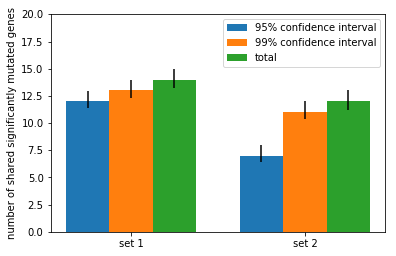

In [38]:
## binomial implementation
input1="statistical_validation/all_clone/mut_lim/set1.txt"
input2="statistical_validation/all_clone/mut_lim/set2.txt"
set1=pd.read_csv(input1,sep='\t')
set2=pd.read_csv(input2,sep='\t')

set1_size=len(set1['Tumor_Sample_Barcode'].unique())
set2_size=len(set2['Tumor_Sample_Barcode'].unique())

sig_list="statistical_validation/all_clone/mut_lim/sig_genes_set1_RNA.txt"
sig_gene_valid=pd.read_csv(sig_list,sep='\t')
sig_gene_valid=sig_gene_valid[sig_gene_valid['q']<0.1]
sig_gene_valid.loc[sig_gene_valid['gene'].str.match("LY75"),'gene']="LY75-CD302"
#sig_gene_valid.loc[sig_gene_valid['gene'].str.match("KIAA0141"),'gene']="DELE1"
#sig_gene_valid.loc[sig_gene_valid['gene'].str.match("ZMYND17"),'gene']="MSS51"

set1=set1.loc[set1['Hugo_Symbol'].isin(sig_gene_valid['gene']),:]

set2=set2.loc[set2['Hugo_Symbol'].isin(sig_gene_valid['gene']),:]

valid1_counts=set1.groupby(['Hugo_Symbol']).size().reset_index(name='counts')
valid2_counts=set2.groupby(['Hugo_Symbol']).size().reset_index(name='counts')

valid_merge=valid1_counts.merge(valid2_counts,how="outer",on=["Hugo_Symbol"])

valid_merge=valid_merge.fillna(0)
valid_merge["poisson_p_tail1"]=1
valid_merge["poisson_p_tail2"]=1

for idx,row in valid_merge.iterrows():
        valid_merge.loc[idx,"poisson_p_tail1"]=stats.binom_test(row['counts_y'],set2_size,
                                                               row['counts_x']/set1_size)
    
print(valid_merge)

set1=pd.read_csv(input1,sep='\t')
set2=pd.read_csv(input2,sep='\t')

sig_list="statistical_validation/all_clone/mut_lim/sig_genes_set2_RNA.txt"
sig_gene_valid=pd.read_csv(sig_list,sep='\t')

sig_gene_valid=sig_gene_valid[sig_gene_valid['q']<0.1]
sig_gene_valid.loc[sig_gene_valid['gene'].str.match("MYST3"),'gene']="KAT6A"

set1=set1.loc[set1['Hugo_Symbol'].isin(sig_gene_valid['gene']),:]
set2=set2.loc[set2['Hugo_Symbol'].isin(sig_gene_valid['gene']),:]

valid1_counts=set1.groupby(['Hugo_Symbol']).size().reset_index(name='counts')
valid2_counts=set2.groupby(['Hugo_Symbol']).size().reset_index(name='counts')

valid_merge2=valid2_counts.merge(valid1_counts,how="outer",on=["Hugo_Symbol"])

valid_merge2=valid_merge2.fillna(0)
valid_merge2["poisson_p_tail1"]=1
valid_merge2["poisson_p_tail2"]=1

for idx,row in valid_merge2.iterrows():
    valid_merge2.loc[idx,"poisson_p_tail1"]=stats.binom_test(row['counts_y'],set1_size,
                                                                row['counts_x']/set2_size)

print(valid_merge2)
overlap1=[len(valid_merge[(valid_merge['poisson_p_tail1']>0.05)].index),
         len(valid_merge2[(valid_merge2['poisson_p_tail1']>0.05)].index)]

overlap2=[len(valid_merge[(valid_merge['poisson_p_tail1']>0.01)].index),
         len(valid_merge2[(valid_merge2['poisson_p_tail1']>0.01)].index)]
                                                                  
# overlap1=[len(valid_merge[(valid_merge['poisson_p_tail1']>0.05)&(valid_merge['poisson_p_tail2']>0.05)].index),
#          len(valid_merge2[(valid_merge2['poisson_p_tail1']>0.05)&(valid_merge2['poisson_p_tail2']>0.05)].index)]
# print(overlap1)
                                                                  
# overlap2=[len(valid_merge[(valid_merge['poisson_p_tail1']>0.01)&(valid_merge['poisson_p_tail2']>0.01)].index),
#          len(valid_merge2[(valid_merge2['poisson_p_tail1']>0.01)&(valid_merge2['poisson_p_tail2']>0.01)].index)]
# print(overlap2)

overlap3=[len(valid_merge.index),len(valid_merge2.index)]

ci_low_1_1, ci_upp_1_1 = proportion_confint(len(valid_merge[
    (valid_merge['poisson_p_tail1']>0.05)].index),
                                        len(valid_merge.index), alpha=0.05, method='binom_test')
                                            
ci_low_1_2, ci_upp_1_2 = proportion_confint(len(valid_merge[
    (valid_merge['poisson_p_tail1']>0.01)].index),
                                        len(valid_merge.index), alpha=0.05, method='binom_test')

ci_low_1_3, ci_upp_1_3 = proportion_confint(len(valid_merge.index),
                                        len(valid_merge.index), alpha=0.05, method='binom_test')

ci_low_2_1, ci_upp_2_1 = proportion_confint(len(valid_merge2[
    (valid_merge['poisson_p_tail1']>0.05)].index),
                                        len(valid_merge2.index), alpha=0.05, method='binom_test')
                                            
ci_low_2_2, ci_upp_2_2 = proportion_confint(len(valid_merge2[
    (valid_merge['poisson_p_tail1']>0.01)].index),
                                        len(valid_merge2.index), alpha=0.05, method='binom_test')

ci_low_2_3, ci_upp_2_3 = proportion_confint(len(valid_merge2.index),
                                        len(valid_merge2.index), alpha=0.05, method='binom_test')

plt.gcf().clear()

axes=plt.gca()
axes.set_ylim([0,20])

barWidth = 0.25
r1 = np.arange(len(overlap1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

p1=plt.bar(r1, overlap1,width=barWidth,label="95% confidence interval")
plt.errorbar(r1[0],overlap1[0], yerr=np.array([[ci_low_1_1,ci_upp_1_1]]).T,ecolor='black')
plt.errorbar(r1[1],overlap1[1], yerr=np.array([[ci_low_2_1,ci_upp_2_1]]).T,ecolor='black')
p2=plt.bar(r2, overlap2,width=barWidth,label="99% confidence interval")
plt.errorbar(r2[0],overlap2[0], yerr=np.array([[ci_low_1_2,ci_upp_1_2]]).T,ecolor='black')
plt.errorbar(r2[1],overlap2[1], yerr=np.array([[ci_low_2_2,ci_upp_2_2]]).T,ecolor='black')
p3=plt.bar(r3, overlap3,width=barWidth,label="total")
plt.errorbar(r3[0],overlap3[0], yerr=np.array([[ci_low_1_3,ci_upp_1_3]]).T,ecolor='black')
plt.errorbar(r3[1],overlap3[1], yerr=np.array([[ci_low_2_3,ci_upp_2_3]]).T,ecolor='black')
plt.xticks([r + barWidth for r in range(len(overlap1))], ('set 1', 'set 2','set 3'))
plt.ylabel('number of shared significantly mutated genes')
plt.legend()

plt.savefig("statistical_validation/all_clone/mut_lim/overlap_genes_errorbar_5mut.png")

# oddsratio, pvalue = stats.fisher_exact([overlap1, [a_i - b_i for a_i, b_i in zip(overlap3, overlap1)]])
# print(pvalue)

# oddsratio, pvalue = stats.fisher_exact([overlap2, [a_i - b_i for a_i, b_i in zip(overlap3, overlap2)]])
# print(pvalue)


In [23]:
#two-tail for genes as well
print([stats.poisson.cdf(8,12),1-stats.poisson.cdf(16,12),stats.poisson.cdf(11,14),1-stats.poisson.cdf(17,14)])

[0.15502778176746304, 0.10129100743983788, 0.2600399224594338, 0.17279938076448687]


In [29]:
array=range(0,75)
print(arar)

75


   Hugo_Symbol  counts_x  counts_y  binom_p_tail1  binom_p_tail2       binom_q
0        ASXL1      17.0       167   1.537032e-02              1  5.520901e-02
1          ATM      18.0       160   4.443128e-03              1  1.950293e-02
2        CARD6      12.0        62   1.692059e-04              1  1.252124e-03
3          CBL       8.0        79   8.060275e-02              1  1.863939e-01
4      CCDC123      11.0        30   9.806364e-07              1  1.209452e-05
5        CEP70       1.0        32   1.000000e+00              1  1.000000e+00
6        CSF1R       3.0        93   4.983329e-01              1  7.145876e-01
7       DNMT3A      49.0       870   7.437219e-01              1  9.172570e-01
8        FANCA       3.0        97   5.021427e-01              1  7.145876e-01
9         GNB1       5.0        36   4.725724e-02              1  1.165679e-01
10      HIVEP2       7.0       124   8.435723e-01              1  1.000000e+00
11        IDH2       1.0        21   1.000000e+00   

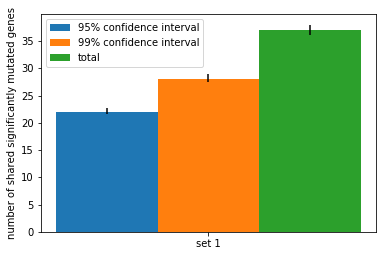

In [25]:
## binomial test ##
input1="~/Documents/COPD/binomial_all_var/pre_whitelist_binomial_noBatch.txt"
input2="whole_set_valid/all_mutations_in_CHIP_genes_strictQ.txt"
set1=pd.read_csv(input1,sep='\t')
set2=pd.read_csv(input2,sep='\t')


sig_genes=pd.read_csv("all_clone/all_clone_mut_lim/sig_genes_5mut_RNA.txt",sep='\t')
sig_genes=sig_genes[sig_genes['q']<0.1]
sig_genes=sig_genes.reset_index(drop=True)

set1.loc[set1['Hugo_Symbol'].str.match("KAT6A"),'Hugo_Symbol']="MYST3"
set1.loc[set1['Hugo_Symbol'].str.match("CEP89"),'Hugo_Symbol']="CCDC123"

set2.loc[set2['Hugo_Symbol'].str.match("KAT6A"),'Hugo_Symbol']="MYST3"
set2.loc[set2['Hugo_Symbol'].str.match("CEP89"),'Hugo_Symbol']="CCDC123"

set1=set1.loc[set1['Hugo_Symbol'].isin(sig_genes['gene']),:]
set1=set1.reset_index(drop=True)

set1=set1.loc[~set1['Variant_Classification'].str.match("Silent"),:]
set1=set1.reset_index(drop=True)

set2=set2.loc[set2['Hugo_Symbol'].isin(sig_genes['gene']),:]
set2=set2.reset_index(drop=True)

valid1_counts=set1.groupby(['Hugo_Symbol']).size().reset_index(name='counts')
valid2_counts=set2.groupby(['Hugo_Symbol']).size().reset_index(name='counts')

valid_merge=valid1_counts.merge(valid2_counts,how="outer",on=["Hugo_Symbol"])

valid_merge=valid_merge.fillna(0)
valid_merge["binom_p_tail1"]=1
valid_merge["binom_p_tail2"]=1

for idx,row in valid_merge.iterrows():
    #if row['counts_y']<row['counts_x']:
    valid_merge.loc[idx,"binom_p_tail1"]=stats.binom_test(row['counts_x'],len(set1['Tumor_Sample_Barcode'].unique()),
                                                          row['counts_y']/len(set2['Tumor_Sample_Barcode'].unique()))

valid_merge['binom_q']=multi.multipletests(valid_merge['binom_p_tail1'],method='fdr_bh')[1]
#         valid_merge.loc[idx,"poisson_p_tail2"]=1-stats.poisson.cdf(row['counts_y']+(
#         row['counts_x']-row['counts_y']),row['counts_x'])
#     else:
#         valid_merge.loc[idx,"poisson_p_tail1"]=1-stats.poisson.cdf(row['counts_y'],row['counts_x'])
#         valid_merge.loc[idx,"poisson_p_tail2"]=stats.poisson.cdf(row['counts_y']-(
#             row['counts_y']-row['counts_x']),row['counts_x'])
    
print(valid_merge)


overlap1=[len(valid_merge[(valid_merge['binom_p_tail1']>0.05)].index)]

overlap2=[len(valid_merge[(valid_merge['binom_p_tail1']>0.01)].index)]

overlap3=[len(valid_merge.index)]
print([overlap1,overlap2,overlap3])

ci_low_1_1, ci_upp_1_1 = proportion_confint(len(valid_merge[
    (valid_merge['binom_p_tail1']>0.05)].index),
                                        len(valid_merge.index), alpha=0.05, method='binom_test')
                                            
ci_low_1_2, ci_upp_1_2 = proportion_confint(len(valid_merge[
    (valid_merge['binom_p_tail1']>0.01)].index),
                                        len(valid_merge.index), alpha=0.05, method='binom_test')

ci_low_1_3, ci_upp_1_3 = proportion_confint(len(valid_merge.index),
                                        len(valid_merge.index), alpha=0.05, method='binom_test')

plt.gcf().clear()

# axes=plt.gca()
# axes.set_ylim([0,20])

barWidth = 0.25
r1 = np.arange(len(overlap1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

p1=plt.bar(r1, overlap1,width=barWidth,label="95% confidence interval")
plt.errorbar(r1[0],overlap1[0], yerr=np.array([[ci_low_1_1,ci_upp_1_1]]).T,ecolor='black')
p2=plt.bar(r2, overlap2,width=barWidth,label="99% confidence interval")
plt.errorbar(r2[0],overlap2[0], yerr=np.array([[ci_low_1_2,ci_upp_1_2]]).T,ecolor='black')
p3=plt.bar(r3, overlap3,width=barWidth,label="total")
plt.errorbar(r3[0],overlap3[0], yerr=np.array([[ci_low_1_3,ci_upp_1_3]]).T,ecolor='black')
plt.xticks([r + barWidth for r in range(len(overlap1))], ('set 1', 'set 2','set 3'))
plt.ylabel('number of shared significantly mutated genes')
plt.legend()

#plt.savefig("statistical_validation/all_clone/mut_lim/overlap_genes_errorbar_5mut.png")

# oddsratio, pvalue = stats.fisher_exact([overlap1, [a_i - b_i for a_i, b_i in zip(overlap3, overlap1)]])
# print(pvalue)

# oddsratio, pvalue = stats.fisher_exact([overlap2, [a_i - b_i for a_i, b_i in zip(overlap3, overlap2)]])
# print(pvalue)


In [35]:
print(stats.poisson.cdf(7,12))

0.08950449684017583
